In [1]:
from transformers import ElectraModel, ElectraTokenizer

pretrained_model = ElectraModel.from_pretrained("monologg/koelectra-base-v3-discriminator")
tokenizer = ElectraTokenizer.from_pretrained("monologg/koelectra-base-v3-discriminator")

/usr/local/lib/python3.8/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torch/_utils.py:776: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


In [2]:
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer
import pandas as pd
from sklearn.model_selection import train_test_split

class SentimentDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len
        
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        
        inputs = self.tokenizer.encode_plus(
            text,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            return_token_type_ids=False,
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )
        
        return {
            'input_ids': inputs['input_ids'].flatten(),
            'attention_mask': inputs['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

def create_data_loader(df, tokenizer, max_len, batch_size):
    dataset = SentimentDataset(
        texts=df['Sentence'].values,
        labels=df['Emotion'].values,
        tokenizer=tokenizer,
        max_len=max_len
    )
    
    return DataLoader(dataset, batch_size=batch_size, shuffle=True)


In [3]:
# 데이터 로드 및 라벨링
filename = './dataset/encoded_dialog_dataset.csv'
df = pd.read_csv(filename)
print(df)

                              Sentence Emotion
0                          김상수 정인욱 보내라      중립
1                     특검은 대한민국이 응원합니다.      행복
2                 거기서는 정말 행복하길 바랍니다…ㅠㅠ      슬픔
3                          마블리가 왜 여기..      놀람
4               긍게 언제쯤 온다고?! 왜 말이 없나?!      분노
...                                ...     ...
38589               좀 무섭기도 하고 그런거예요 ㅠㅠ      슬픔
38590  해외 장거리로 헤어져서 지금은 헤어진지 육개월정도 됐어요      슬픔
38591       난 가족이랑 있을땐 오히려 폰 안하는데.....      중립
38592                노트7 팔려고 못들어오게 하나바      공포
38593   우리 시어머니평범한 50댄데 자꾸 이런글 퍼다날림...      중립

[38594 rows x 2 columns]


In [4]:
# 라벨 매핑
label_mapping = {'놀람': 2, '행복': 2, '공포': 0, '분노': 0, '슬픔': 0, '혐오': 0, '중립': 1}
df['Emotion'] = df['Emotion'].map(label_mapping)

# 각 레이블 값의 개수 계산
counts = df['Emotion'].value_counts()
print(counts)


Emotion
0    21829
2    11935
1     4830
Name: count, dtype: int64


In [5]:
print(df)

                              Sentence  Emotion
0                          김상수 정인욱 보내라        1
1                     특검은 대한민국이 응원합니다.        2
2                 거기서는 정말 행복하길 바랍니다…ㅠㅠ        0
3                          마블리가 왜 여기..        2
4               긍게 언제쯤 온다고?! 왜 말이 없나?!        0
...                                ...      ...
38589               좀 무섭기도 하고 그런거예요 ㅠㅠ        0
38590  해외 장거리로 헤어져서 지금은 헤어진지 육개월정도 됐어요        0
38591       난 가족이랑 있을땐 오히려 폰 안하는데.....        1
38592                노트7 팔려고 못들어오게 하나바        0
38593   우리 시어머니평범한 50댄데 자꾸 이런글 퍼다날림...        1

[38594 rows x 2 columns]


In [6]:
additional_filename = './dataset/additional.csv'
df_additional = pd.read_csv(additional_filename)
print(df_additional)

                                                Sentence  Emotion
0                               가격대비! 좋아요! 음량도 크고! 구매하세요        2
1                   화질도 괜찮고 타사 제품에 비해 길이가 1M정도 더 길어서 좋아요        2
2      생각보다 상당히 빨리 받았네요. OO에서 직접 배송해주는거라 설치 기사가 직접 배송...        1
3                               팬소음이 너무 심하고 업그레이드가 불편하네요        0
4      대학입학한 딸이 쓰기 딱 적당합니다 고급사양이라고 하긴 뭐하지만 가성비로는 이보다 ...        2
...                                                  ...      ...
40403  단말기 연결하는거 어렵지 않고 잘 되서 좋아요  후불 지급방식으로 자동으로 결제되게...        2
40404  단말기기가 작아서 차안 인테리어와 잘 어울려서 좋아요 디자인이 깔끔하고 세련되서 이...        2
40405  자가등록도 간편해서 오래 안걸렸고 괜찮았네요 운전석 앞에 두었는데 인식 잘 되서 마...        2
40406  충전카드를 구매하고 자가등록을 완료하는 과정이 간단해서 좋아요 디자인이 차안에 맞고...        2
40407  화이트 색상이 세련되고 깔끔하고 이쁘네요  걸리적거리지 않아 편하네요 선이 없어 깔...        2

[40408 rows x 2 columns]


In [7]:
df_added = pd.concat([df, df_additional], ignore_index=False)
print(df_added)

# 각 레이블 값의 개수 계산
counts = df_added['Emotion'].value_counts()
print(counts)

# 'Emotion' 열에 대한 각 라벨 값의 개수 계산
counts = df_added['Emotion'].value_counts()
print("기존의 각 라벨 값의 개수:\n", counts)

# 가장 적은 라벨의 개수 찾기
min_count = counts.min()

# 각 라벨별로 min_count만큼 데이터를 무작위로 선택
balanced_df_list = []
for label in counts.index:
    # 현재 라벨의 데이터만 필터링
    df_filtered = df_added[df_added['Emotion'] == label]
    # 무작위로 min_count만큼 샘플링
    df_sampled = df_filtered.sample(n=min_count, random_state=1)
    balanced_df_list.append(df_sampled)

# 선택된 데이터를 합쳐 새로운 데이터프레임 만들기
balanced_df = pd.concat(balanced_df_list, ignore_index=True)

# 결과 확인
print("\n새로운 데이터셋의 크기:", balanced_df.shape)
print("\n새로운 데이터셋의 각 라벨 값의 개수:\n", balanced_df['Emotion'].value_counts())


                                                Sentence  Emotion
0                                            김상수 정인욱 보내라        1
1                                       특검은 대한민국이 응원합니다.        2
2                                   거기서는 정말 행복하길 바랍니다…ㅠㅠ        0
3                                            마블리가 왜 여기..        2
4                                 긍게 언제쯤 온다고?! 왜 말이 없나?!        0
...                                                  ...      ...
40403  단말기 연결하는거 어렵지 않고 잘 되서 좋아요  후불 지급방식으로 자동으로 결제되게...        2
40404  단말기기가 작아서 차안 인테리어와 잘 어울려서 좋아요 디자인이 깔끔하고 세련되서 이...        2
40405  자가등록도 간편해서 오래 안걸렸고 괜찮았네요 운전석 앞에 두었는데 인식 잘 되서 마...        2
40406  충전카드를 구매하고 자가등록을 완료하는 과정이 간단해서 좋아요 디자인이 차안에 맞고...        2
40407  화이트 색상이 세련되고 깔끔하고 이쁘네요  걸리적거리지 않아 편하네요 선이 없어 깔...        2

[79002 rows x 2 columns]
Emotion
2    36090
0    25611
1    17301
Name: count, dtype: int64
기존의 각 라벨 값의 개수:
 Emotion
2    36090
0    25611
1    17301
Name: count, dtype: int64

새로운 데이터셋의 크기: (51903, 2)

새로운 

평균 토큰 수: 39.52047087836927
중앙값 토큰 수: 26.0
최대 토큰 수: 618


/usr/local/lib/python3.8/dist-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 48712 (\N{HANGUL SYLLABLE BIN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.8/dist-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 46020 (\N{HANGUL SYLLABLE DO}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.8/dist-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 47928 (\N{HANGUL SYLLABLE MUN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.8/dist-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 51109 (\N{HANGUL SYLLABLE JANG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.8/dist-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 48324 (\N{HANGUL SYLLABLE BYEOL}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.8/dist-packages/IPyt

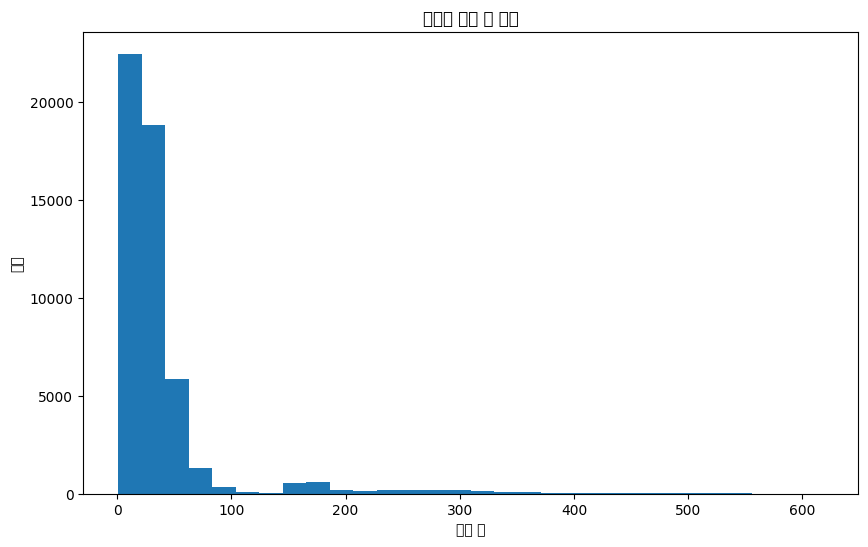

In [8]:
# 문장들의 토큰 수를 계산해서, model_max_length값을 결정한다.
import matplotlib.pyplot as plt
token_counts = balanced_df['Sentence'].apply(lambda x: len(tokenizer.tokenize(x)))

# 기본 통계 정보 출력
print("평균 토큰 수:", token_counts.mean())
print("중앙값 토큰 수:", token_counts.median())
print("최대 토큰 수:", token_counts.max())

plt.figure(figsize=(10, 6))
plt.hist(token_counts, bins=30)
plt.title('문장별 토큰 수 분포')
plt.xlabel('토큰 수')
plt.ylabel('빈도')
plt.show()

In [9]:
# 데이터셋 분할
train_df, test_df = train_test_split(balanced_df, test_size=0.25, random_state=32)
val_df, test_df = train_test_split(test_df, test_size=0.5, random_state=32)

# 데이터 로더 생성
max_len = 256
batch_size = 32

train_data_loader = create_data_loader(train_df, tokenizer, max_len, batch_size)
val_data_loader = create_data_loader(val_df, tokenizer, max_len, batch_size)
test_data_loader = create_data_loader(test_df, tokenizer, max_len, batch_size)


In [10]:
print(df)

                              Sentence  Emotion
0                          김상수 정인욱 보내라        1
1                     특검은 대한민국이 응원합니다.        2
2                 거기서는 정말 행복하길 바랍니다…ㅠㅠ        0
3                          마블리가 왜 여기..        2
4               긍게 언제쯤 온다고?! 왜 말이 없나?!        0
...                                ...      ...
38589               좀 무섭기도 하고 그런거예요 ㅠㅠ        0
38590  해외 장거리로 헤어져서 지금은 헤어진지 육개월정도 됐어요        0
38591       난 가족이랑 있을땐 오히려 폰 안하는데.....        1
38592                노트7 팔려고 못들어오게 하나바        0
38593   우리 시어머니평범한 50댄데 자꾸 이런글 퍼다날림...        1

[38594 rows x 2 columns]


In [11]:
import wandb

# init
wandb.init(project='KoELECTRA_Emotion_Classification', 
           group='yuhohyun',
           name='2024-05-25(5)(dropout=0.1)',
           notes='Epoch = 20, max_len = 256, batch_size = 32, lr=7e-7',
           tags='T',
           entity='yuhohyun')

# config
wandb.config = {
  "learning_rate": 7e-7,
  "epochs": 20,
  "batch_size": 32,
  "max_len" : 256
}

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: yuhohyun. Use `wandb login --relogin` to force relogin


In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from transformers import AdamW, get_linear_schedule_with_warmup
from torchmetrics import Precision, Recall, F1Score
import numpy as np

In [13]:
class CustomTransformerModel(nn.Module):
    def __init__(self, model, num_labels, num_cls_vector):
        super(CustomTransformerModel, self).__init__()
        self.num_labels = num_labels
        self.num_cls_vector = num_cls_vector  # 이 줄을 추가하여 num_cls_vector를 클래스 변수로 저장

        self.model = model
        self.dropout = nn.Dropout(0.1)
        self.classifier = nn.Linear(num_cls_vector, num_labels)  # load and initialize weights

    def forward(self, input_ids=None, attention_mask=None, labels=None):
        # Extract outputs from the body
        outputs = self.model(input_ids=input_ids, attention_mask=attention_mask)

        # Add custom layers
        sequence_output = self.dropout(outputs[0])  # outputs[0]=last hidden state
        # 제공할 최종 logits 계산
        logits = self.classifier(sequence_output[:, 0, :].view(-1, self.num_cls_vector))  # 여기서 self.num_cls_vector를 사용

        return logits

In [14]:
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np

In [15]:
def train_validate_model(model, train_loader, val_loader, criterion, optimizer, scheduler, device, num_epochs):
    for epoch in range(num_epochs):
        model.train()
        train_loss, train_corrects, train_steps = 0.0, 0, 0
        train_precision, train_recall, train_f1 = Precision(average='macro', num_classes=3, task='multiclass').to(device), Recall(average='macro', num_classes=3, task='multiclass').to(device), F1Score(average='macro', num_classes=3, task='multiclass').to(device)
        
        # tqdm으로 학습 데이터 로더 감싸기
        train_loader_tqdm = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} Training")
        for batch in train_loader_tqdm:
            inputs = {
                'input_ids': batch['input_ids'].to(device),
                'attention_mask': batch['attention_mask'].to(device)
            }
            labels = batch['labels'].to(device)

            optimizer.zero_grad()

            outputs = model(**inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            preds = outputs.argmax(dim=1)
            train_loss += loss.item() * inputs['input_ids'].size(0)
            train_corrects += torch.sum(preds == labels.data)
            train_steps += 1

            # 메트릭 업데이트
            train_precision.update(preds, labels)
            train_recall.update(preds, labels)
            train_f1.update(preds, labels)
        
        scheduler.step()

        train_loss = train_loss / len(train_loader.dataset)
        train_acc = train_corrects.double() / len(train_loader.dataset)
        train_precision, train_recall, train_f1 = train_precision.compute(), train_recall.compute(), train_f1.compute()

        # 검증
        model.eval()
        val_loss, val_corrects, val_steps = 0.0, 0, 0
        val_precision, val_recall, val_f1 = Precision(average='macro', num_classes=3, task='multiclass').to(device), Recall(average='macro', num_classes=3, task='multiclass').to(device), F1Score(average='macro', num_classes=3, task='multiclass').to(device)

        # tqdm으로 검증 데이터 로더 감싸기
        val_loader_tqdm = tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} Validation")
        with torch.no_grad():
            for batch in val_loader_tqdm:
                inputs = {
                    'input_ids': batch['input_ids'].to(device),
                    'attention_mask': batch['attention_mask'].to(device)
                }
                labels = batch['labels'].to(device)

                outputs = model(**inputs)
                loss = criterion(outputs, labels)

                preds = outputs.argmax(dim=1)
                val_loss += loss.item() * inputs['input_ids'].size(0)
                val_corrects += torch.sum(preds == labels.data)
                val_steps += 1

                # 메트릭 업데이트
                val_precision.update(preds, labels)
                val_recall.update(preds, labels)
                val_f1.update(preds, labels)

        val_loss = val_loss / len(val_loader.dataset)
        val_acc = val_corrects.double() / len(val_loader.dataset)
        val_precision, val_recall, val_f1 = val_precision.compute(), val_recall.compute(), val_f1.compute()


        # 로깅
        wandb.log({
            "epoch": epoch + 1,
            "train_loss": train_loss, "train_acc": train_acc.item(),
            "train_precision": train_precision.item(), "train_recall": train_recall.item(), "train_f1": train_f1.item(),
            "val_loss": val_loss, "val_acc": val_acc.item(),
            "val_precision": val_precision.item(), "val_recall": val_recall.item(), "val_f1": val_f1.item()
        })

        print(f'Epoch {epoch+1}/{num_epochs} - Train loss: {train_loss:.4f}, Acc: {train_acc:.4f}, Precision: {train_precision:.4f}, Recall: {train_recall:.4f}, F1: {train_f1:.4f}')
        print(f'Validation loss: {val_loss:.4f}, Acc: {val_acc:.4f}, Precision: {val_precision:.4f}, Recall: {val_recall:.4f}, F1: {val_f1:.4f}')


In [16]:
# 모델 초기화
model = CustomTransformerModel(model=pretrained_model, num_labels=3, num_cls_vector=768)

#손실 함수
criterion = nn.CrossEntropyLoss()

# 실제 학습 실행
epochs = 20

# 최적화 함수 및 손실 함수
optimizer = AdamW(model.parameters(), lr=7e-7, correct_bias=False)
total_steps = len(train_data_loader) * epochs # epochs는 학습할 총 에폭 수

# 스케줄러는 선택사항
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

loss_fn = nn.CrossEntropyLoss()

# 모델을 학습시키는 데 사용할 장비 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:521: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
train_validate_model(model, train_data_loader, val_data_loader, criterion, optimizer, scheduler, device, epochs)

### 학습한 model 저장

In [18]:
# 모델 저장 경로 지정
model_save_path = 'model.pth'

# 모델의 state_dict 저장
torch.save(model.state_dict(), model_save_path)

print(f'Model saved to {model_save_path}')


Model saved to model.pth


### 사용자가 입력한 text로 test

In [ ]:
text = "시간이 충분하셨을 텐데, 정말 많이 하셨네요."
encoded_input = tokenizer(text, return_tensors='pt', add_special_tokens=True)

# 'token_type_ids' 제거
if 'token_type_ids' in encoded_input:
    del encoded_input['token_type_ids']

# GPU 사용 가능 여부 확인
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 모델을 해당 디바이스로 이동
model.to(device)

# 입력 데이터를 해당 디바이스로 이동
# 예를 들어, encoded_input이 입력 데이터라면
encoded_input = {k: v.to(device) for k, v in encoded_input.items()}

with torch.no_grad():
    outputs = model(input_ids=encoded_input['input_ids'], attention_mask=encoded_input['attention_mask'])

# 예측 결과 처리
# 직접 반환된 텐서를 logits 변수에 할당합니다.
logits = outputs

predicted_index = torch.argmax(logits, dim=1).item()

if predicted_index == 2:
    print('positive')
elif predicted_index == 1:
    print('neutral')
elif predicted_index == 0:
    print('negative')